# Driver innatention detector

### Opis podatkov s strani kaggle
This comprehensive gray-scale dataset is a valuable resource for researchers and developers in the field of computer vision, machine learning and deep learning, particularly those focused on driver behavior analysis and driver assistance systems. Comprising over 14,000 labeled images across six distinct classes, it provides a diverse and extensive collection for training, validation, and testing purposes, specifically tailored for gray-scale image processing.

The dataset is organized into three main directories:

Training Set (train):This directory contains 11,942 gray-scale images, carefully curated and labeled across the six classes.

Validation Set (validation): With 1,922 gray-scale images, this subset provides a means for fine-tuning models and evaluating their performance during development.

Test Set (test): Comprising 985 gray-scale images, this directory is reserved for final model evaluation and benchmarking.

The dataset encompasses six classes of driving behaviors:

1- Dangerous Driving: Gray-scale images capturing instances of reckless or hazardous driving behavior, such as speeding or erratic lane changes.
2- Distracted Driving: Instances where the driver's attention is diverted away from the road, possibly due to smartphone usage, eating, or interacting with passengers.
3- Drinking: Gray-scale images depicting drivers consuming alcoholic beverages while behind the wheel, highlighting the dangers of driving under the influence.
4- Safe Driving: Examples of responsible and cautious driving behavior captured in gray-scale, including obeying traffic laws, maintaining safe distances, and using turn signals.
5- Sleepy Driving: Instances where drivers exhibit signs of drowsiness or fatigue, posing a significant risk of accidents due to reduced alertness, depicted in gray-scale.
6- Yawn: Gray-scale images capturing drivers in the act of yawning, often indicative of fatigue or tiredness, which can impair driving performance.

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/driver-inattention-detection-dataset/README.dataset.txt
/kaggle/input/driver-inattention-detection-dataset/README.roboflow.txt
/kaggle/input/driver-inattention-detection-dataset/valid/gA_1_s2_ir_face_mp4-176_jpg.rf.693fa1c65846758c1cddc0f8415a8766.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gA_2_s2_ir_face_mp4-227_jpg.rf.a3ae53497a4af8b61f5bba0372554b19.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-549_jpg.rf.65e47acbce7c18d72317af02550fba9a.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-354_jpg.rf.2cec3b6e6fd05f56e3561593258d7ea0.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-844_jpg.rf.f6c242cbc1bcef3e8732297d30a0a10f.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-613_jpg.rf.55300d462163c8291b6ca7d1604422fc.jpg
/kag

## Visualization

In [4]:
train_images_path = '/kaggle/input/driver-inattention-detection-dataset/train'
annotation_file_path = '/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt'

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

annotations = {}

with open(annotation_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        
        if len(parts) < 2:
            print(f'skipping due to the incorrect format: {line}')
            continue
            
        image_name = parts[0]
        
        bbox_and_class = parts[1].split(',')
        
        if len(bbox_and_class) <5:
            print(f"Skipping the line due to missing bouding box or class info: {line}")
            continue
            
        class_id = int(bbox_and_class[-1])
        
        annotations[image_name] = class_id

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.f0ab9d03d718ac287cac6fca394783d0.jpg

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.fa7c39ef44d869bdab6c298c89442f19.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.4a274f58e714facd11a3693a3325c3d5.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.c507475339c83c2de42f2400987923d2.jpg



In [5]:
print(type(parts))
print(type(annotations))

<class 'list'>
<class 'dict'>


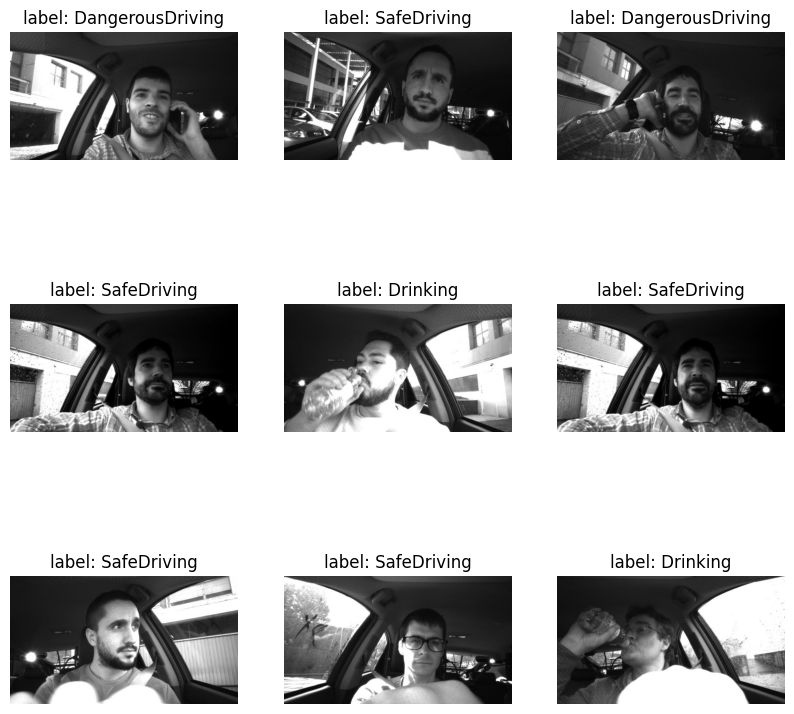

In [6]:
def load_image_and_label(image_name):
    
    img_path = os.path.join(train_images_path, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if image_name in annotations:
        class_id = annotations[image_name]
        return img, class_names[class_id]
    else:
        print(f'Warning: No label found for {image_name}')
        return img, "No label"
    
plt.figure(figsize = (10,10))
image_files = os.listdir(train_images_path)[:9]

for i, image_file in enumerate(image_files):
    img, label = load_image_and_label(image_file)

    ax = plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label: {label}')
    plt.axis('off')

plt.show()

## Preprocessing

In [7]:
def read_annotations(file_path):
    annotations = []
    with open(file_path,'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int,parts[1].split(',')))
                if len(bbox) !=5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(annotations,columns = ['image_name','x_min','y_min','x_max','y_max','class_id'])

In [8]:
target_size = (128,128)
def preprocess_image(image_path,target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,target_size)
    return image  

In [9]:
def one_hot_encode_labels(labels,num_classes):
    encoder = OneHotEncoder(sparse = False)
    labels = np.array(labels).reshape(-1,1)
    one_hot_labels = encoder.fit_transform(labels)
    return one_hot_labels

In [10]:
train_folder = '/kaggle/input/driver-inattention-detection-dataset/train'
test_folder = '/kaggle/input/driver-inattention-detection-dataset/test'
valid_folder = '/kaggle/input/driver-inattention-detection-dataset/valid'

train_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt')
test_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/test/_annotations.txt')
valid_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/valid/_annotations.txt')

In [11]:
def preprocess_dataset(annotations,folder_path,num_classes):
    images = []
    labels = []
    
    for _, row in annotations.iterrows():
        image_path = os.path.join(folder_path,row['image_name'])
        image = preprocess_image(image_path,target_size)
        images.append(image)
        labels.append(row['class_id'])
    images = np.array(images)
    one_hot_labels = one_hot_encode_labels(labels, num_classes)
    return images,one_hot_labels

num_classes = 6

train_images, train_labels = preprocess_dataset(train_annotations,train_folder,num_classes)
test_images, test_labels = preprocess_dataset(test_annotations,test_folder,num_classes)
valid_images, valid_labels = preprocess_dataset(valid_annotations,valid_folder,num_classes)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Stanje dataseta po preprocesiranju

In [12]:
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Valid images shape: {valid_images.shape}')
print(f'Valid labels shape: {valid_labels.shape}')

Train images shape: (11948, 128, 128, 3)
Train labels shape: (11948, 6)
Test images shape: (985, 128, 128, 3)
Test labels shape: (985, 6)
Valid images shape: (1922, 128, 128, 3)
Valid labels shape: (1922, 6)


### Kreacija učne in validacijske množice

In [13]:
(X_train, y_train), (X_val, y_val) = (train_images, train_labels), (valid_images, valid_labels)

## Nevronska mreža (CNN)

### Clasical CNN model

In [16]:
model = Sequential([
    Conv2D(32,(3,3),activation = 'relu',input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(6,activation = 'softmax')
]) 

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,110,598 (19.50 MB)

 Trainable params: 5,110,598 (19.50 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 258s 685ms/step - accuracy: 0.5223 - loss: 6.0590 - val_accuracy: 0.7940 - val_loss: 0.5949
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 254s 680ms/step - accuracy: 0.7833 - loss: 0.6094 - val_accuracy: 0.8361 - val_loss: 0.4893
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 243s 649ms/step - accuracy: 0.8187 - loss: 0.5092 - val_accuracy: 0.8559 - val_loss: 0.4376
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 241s 645ms/step - accuracy: 0.8530 - loss: 0.4185 - val_accuracy: 0.8835 - val_loss: 0.3871
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 238s 637ms/step - accuracy: 0.8787 - loss: 0.3478 - val_accuracy: 0.8762 - val_loss: 0.3800
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 237s 633ms/step - accuracy: 0.8881 - loss: 0.3246 - val_accuracy: 0.8918 - val_loss: 0.3642
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 236s 631ms/step - accuracy: 0.9034 - loss: 0.2815 - val_accuracy: 0.8907 - val_loss: 0.3273
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 238s 636ms/step - accuracy: 0.9076 -

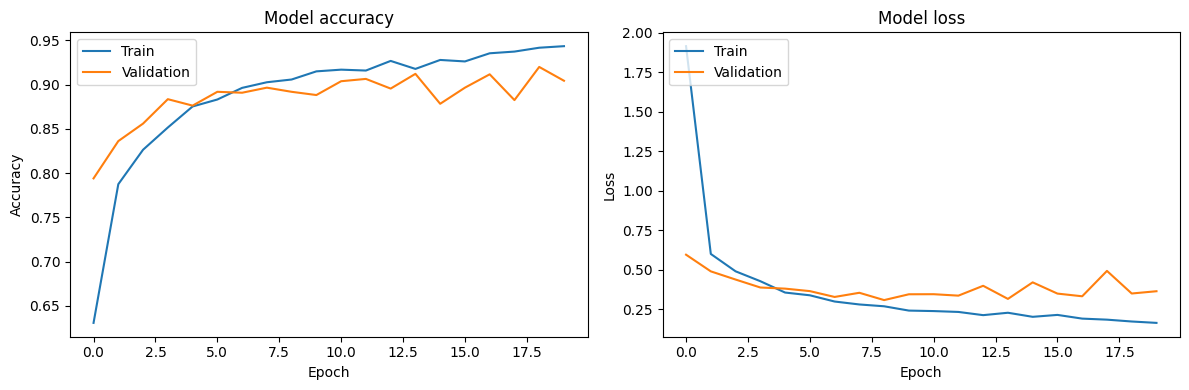

In [19]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


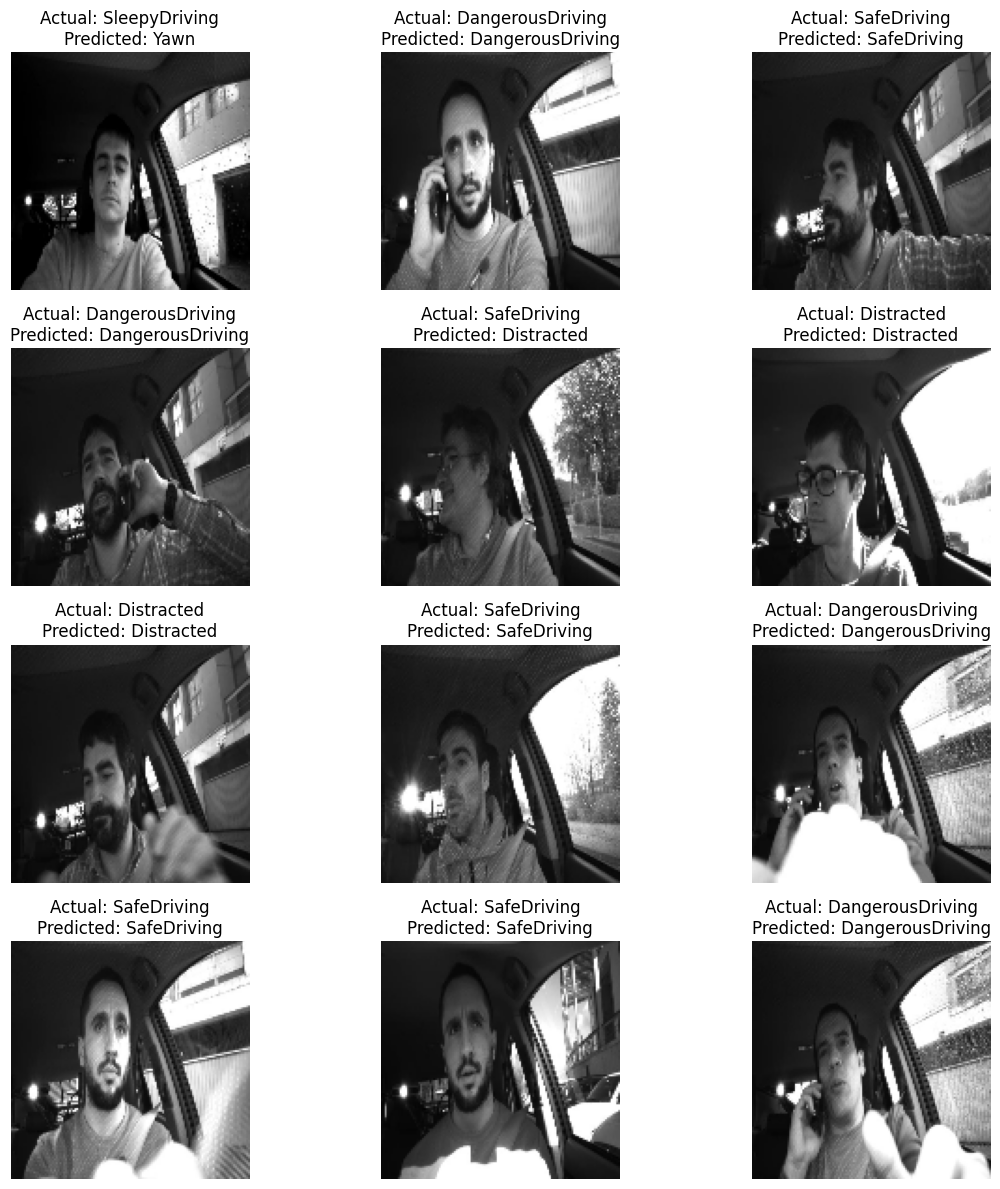

In [20]:
def plot_images_grid_with_predictions(images, actual_labels, predicted_labels, class_names, grid_size=(4, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            actual_label = class_names[np.argmax(actual_labels[i])]
            predicted_label = class_names[np.argmax(predicted_labels[i])]
            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn']

# Select 12 random test images
indices = np.random.choice(len(test_images), 12, replace=False)
sample_images = test_images[indices]
sample_actual_labels = test_labels[indices]

# Predict the labels
sample_predicted_labels = model.predict(sample_images)

# Plot the images in a grid with predictions
plot_images_grid_with_predictions(sample_images, sample_actual_labels, sample_predicted_labels, class_names)

### Accuracy na podlagi testne množice

In [22]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
test_accuracy = test_accuracy * 100
print(f'Test accuracy: {test_accuracy:.2f}%')

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9021 - loss: 0.3452
Test accuracy: 89.85%


### Shranjevanje modela

In [24]:
# Save the entire model
model.save("driver_inattention_detector.keras")


In [25]:
model.save('driving_inattention_model.h5')